In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, time, datetime
from tqdm import tqdm
import math
# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [ ]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/KDT/total_data.csv')
data = data[9:27025] #drop unknwon period(~2017060108, 2020070100~ )
data = data.reset_index(drop = True)
data.columns = ['datetime','solar_result','temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth']
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y%m%d%H')
data.head()

,datetime,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth
0,2017-06-01 09:00:00,33.12,21.000000,0.0,0.0,65.000000,2.400000,111.000000,1.0,44.23,92.42
1,2017-06-01 10:00:00,50.16,21.333333,0.0,0.0,65.000000,2.333333,112.000000,1.0,NaN,NaN
2,2017-06-01 11:00:00,96.72,21.666667,0.0,0.0,65.000000,2.266667,113.000000,1.0,NaN,NaN
3,2017-06-01 12:00:00,120.96,22.000000,0.0,0.0,65.000000,2.200000,114.000000,1.0,76.04,158.50
4,2017-06-01 13:00:00,118.80,21.333333,0.0,0.0,63.333333,2.433333,107.666667,1.0,NaN,NaN


In [ ]:
dataset = data.loc[:,'solar_result' :].astype('float')
dataset.index = data['datetime']
dataset.isnull().sum()

solar_result        0
temp                0
rain_t              0
rain_r              0
hum                 0
wins                0
wind                0
sky                 0
altitude        22512
azimuth         22512
dtype: int64

#01. 학습 데이터 전처리

#SARIMA

In [ ]:
# !pip install pandas_datareader

import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

!pip install pmdarima
from pmdarima.arima import auto_arima

import seaborn as sns

%matplotlib inline

import itertools

import warnings
warnings.filterwarnings('ignore')

###1.Data

In [ ]:
dataset = dataset.drop(['temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth'], axis=1)
dataset.head()

,solar_result
datetime,
2017-06-01 09:00:00,33.12
2017-06-01 10:00:00,50.16
2017-06-01 11:00:00,96.72
2017-06-01 12:00:00,120.96
2017-06-01 13:00:00,118.80


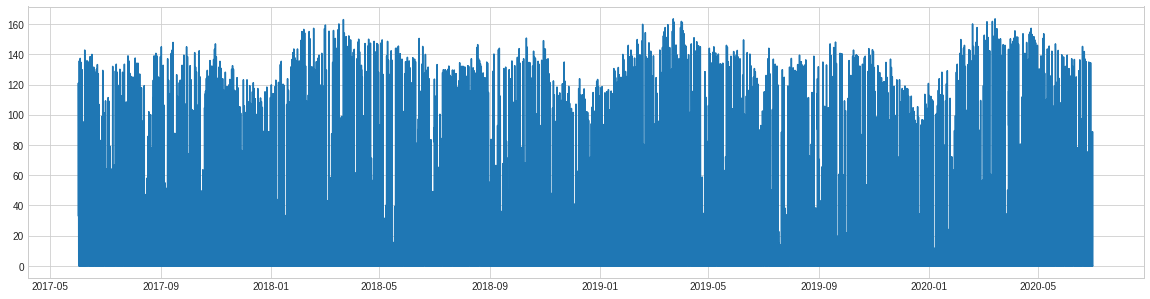

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(dataset)
plt.show()

Seasonal decomposition plot : Seasonal decomposition using moving average
https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

*   Observed : observed data
*   Trend : The estimated trend component
*   Seasonal : The estimated seasonal component
*   resid : The estimated residuals

[시계열분해법](https://leedakyeong.tistory.com/entry/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%ED%95%B4%EB%9E%80Time-Series-Decomposition-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D%EC%9D%B4%EB%9E%80-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%9E%80-%EC%B6%94%EC%84%B8Trend-%EC%88%9C%ED%99%98Cycle-%EA%B3%84%EC%A0%88%EC%84%B1Seasonal-%EB%B6%88%EA%B7%9C%EC%B9%99-%EC%9A%94%EC%86%8CRandom-Residual)


In [ ]:
# decompotion = sm.tsa.seasonal_decompose(dataset['solar_result'], model='additive', period =1)

# decompotion = seasonal_decompose(dataset['solar_result'], model='additive', period =1)
# # TypeError: seasonal_decompose() got an unexpected keyword argument 'period'

# decompotion = seasonal_decompose(dataset['solar_result'], model='additive')
# fig = decompotion.plot()
# fig.set_size_inches(20,10)
# plt.show()

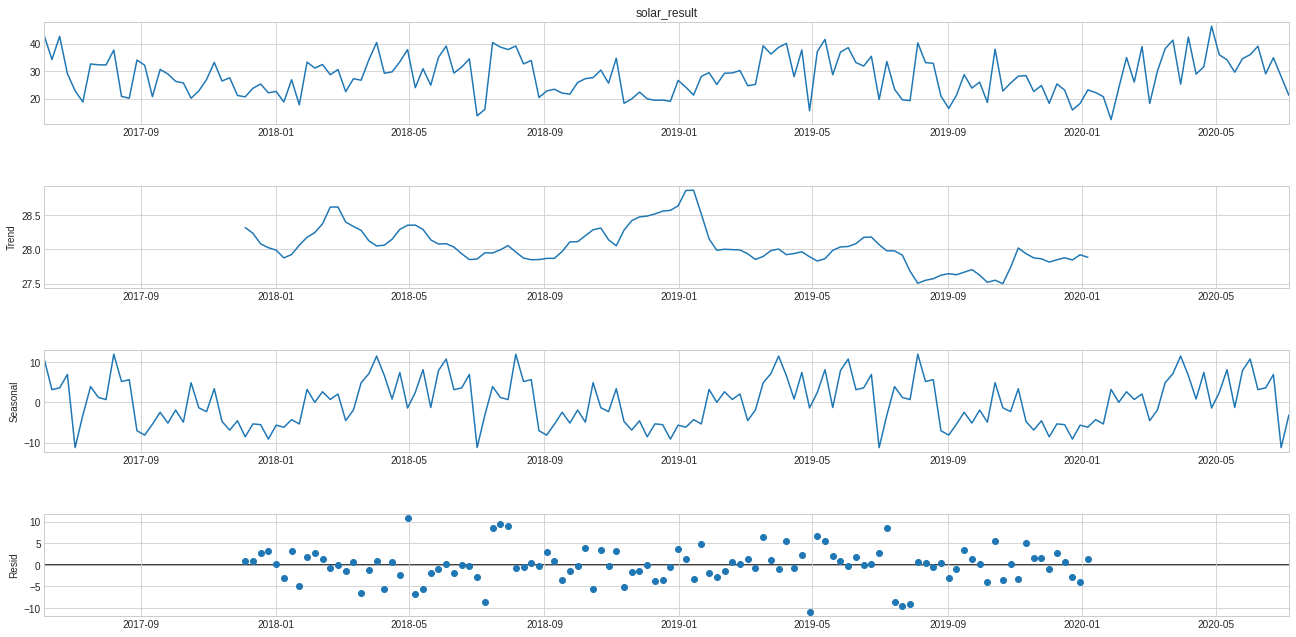

In [ ]:
# seasonal을 보고자 주단위로 그려봄

y = dataset['solar_result'].resample('W-MON').mean()
decompotion = seasonal_decompose(y, model='additive')
fig = decompotion.plot()
fig.set_size_inches(20,10)
plt.show()

In [ ]:
y

datetime
2017-06-05    42.903784
2017-06-12    34.228571
2017-06-19    42.618571
2017-06-26    29.112857
2017-07-03    22.894286
2017-07-10    18.840000
2017-07-17    32.608571
2017-07-24    32.325714
2017-07-31    32.261429
2017-08-07    37.668571
2017-08-14    20.890000
2017-08-21    20.197143
2017-08-28    34.035714
2017-09-04    32.151429
2017-09-11    20.757143
2017-09-18    30.652857
2017-09-25    28.968571
2017-10-02    26.325714
2017-10-09    25.752857
2017-10-16    20.207143
2017-10-23    22.867143
2017-10-30    26.955714
2017-11-06    33.198571
2017-11-13    26.438571
2017-11-20    27.610000
2017-11-27    21.200000
2017-12-04    20.702857
2017-12-11    23.812857
2017-12-18    25.342857
2017-12-25    22.164286
2018-01-01    22.674286
2018-01-08    18.827143
2018-01-15    26.908571
2018-01-22    17.825714
2018-01-29    33.311429
2018-02-05    31.128571
2018-02-12    32.427143
2018-02-19    28.727143
2018-02-26    30.597143
2018-03-05    22.585714
2018-03-12    27.265714
2018-03

###2.Identify Model to be Tentatively Entertainted

In [ ]:
# model_arima= auto_arima(y.values,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=52,suppress_warnings=True,stepwise=False,seasonal=True)

 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=1082.827, Time=5.40 sec
 ARIMA(0,0,0)(1,0,2)[52] intercept   : AIC=1084.884, Time=21.30 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=16.81 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=20.78 sec
 ARIMA(0,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=26.38 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=1090.447, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1082.625, Time=1.43 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=1081.134, Time=6.92 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=1080.336, Time=3.53 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=1080.949, Time=6.49 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=1082.403, Time=24.16 sec
 ARIMA(0,0,1)(2,0,0)[52] intercept   : AIC=1080.531, Time=19.94 sec
 ARIMA(0,0,1)(2,0,1)[52] intercept   : AIC=inf, Time=14.23 sec
 ARIMA(0,0,1)(2,0,2)[52] intercept   : AIC=inf, Time=30.37 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=1087.937, Time=0.10 sec
 ARIMA(0,0,2

In [ ]:
model_opt = SARIMAX(y, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), enforce_stationarity=False, enforce_invertibility=False) # enforce_stationarity=True 시도 # 52를 늘리거나 줄이거나 시도 12~120
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        solar_result   No. Observations:                  162
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                -368.423
Date:                             Mon, 16 Aug 2021   AIC                            744.846
Time:                                     08:12:43   BIC                            755.612
Sample:                                 06-05-2017   HQIC                           749.212
                                      - 07-06-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0006      0.001    667.622      0.000       0.998       1.003
ma.L1         -1.0000     33.236     -0.030      0.976     -66.142      64.142
ar.S.L52       0.4528      0.105      4.298      0.000       0.246       0.659
sigma2        48.3876   1608.359      0.030      0.976   -3103.938    3200.713
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                 0.78
Prob(Q):                              0.18   Prob(JB):                         0.68
Heteroskedasticity (H):               1.31   Skew:                             0.12
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1]:
prediction = model_opt_fit.forecast(100)

NameError: ignored

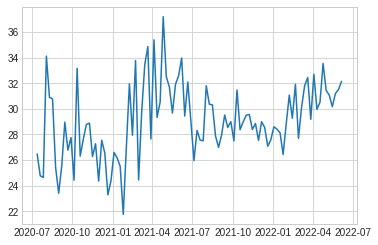

In [ ]:
plt.plot(prediction)

In [ ]:
# test_data['predic'] = prediction[0]
test_data

NameError: ignored

In [ ]:
pred = model_opt_fit.get_prediction(start=pd.to_datetime('2017-06-01'),end=pd.to_datetime('2019-11-18'), dynamic=False)

#Plot observed data
ax = y['2017-06-01':'2019-11-18'].plot(label='Observed')

#Plot predicted data
pred.predicted_mean.plot(ax=ax, label='Model Output', alpha=1, figsize=(14, 7))

#Generate a confidence interval
#pred_ci = pred.conf_int()
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)


forecast = results2.get_prediction(start=pd.to_datetime('2020-07-02'),end=pd.to_datetime('2021-07-02'), dynamic=False)
forecast_ci = forecast.conf_int()
forecast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('solar_power')
plt.legend()
plt.show()

KeyError: ignored

In [ ]:
predict_index = list(y.index)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
y.plot(ax=ax);
# ax.vlines('2019-11-18', 0, 200, linestyle='--', color = 'r', label = 'Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
# ax.plot(predict_index, predicted_value, label = 'Prediction')
# ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label='0.95 Prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score : {round(r2,2)})')

In [ ]:
# Train:Test = 8:2
train_data, test_data = train_test_split(data, test_size = 0.2, shuffle=False)

In [ ]:
# train_data

ACF, PACF plot

https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

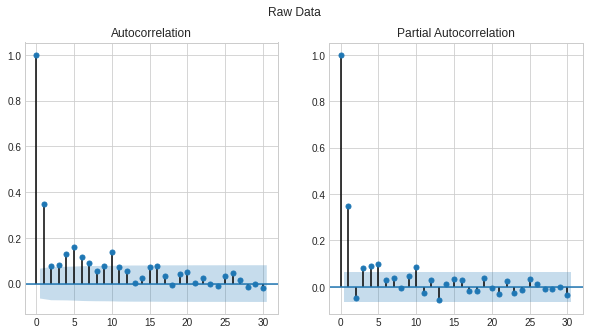

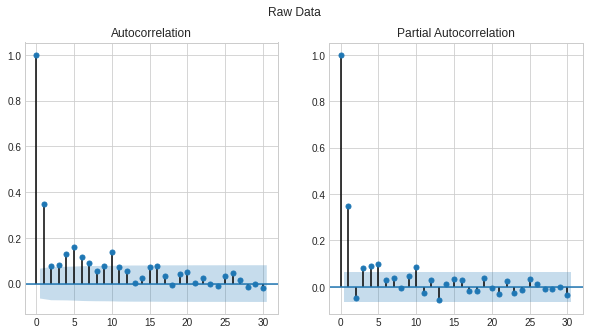

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0]) # 스퀴즈(Squeeze) - 1인 차원을 제거한다.
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])
# sm.graphics.tsa.plot_acf(train_data, lags=30, ax=ax[0])
# sm.graphics.tsa.plot_pacf(train_data, lags=30, ax=ax[1])

# Q) 왜 그래프가 두개나 나오지?
# 결과는 소멸하는 sin함수 형태로서 AR모델이랑 잘맞는 모델로서 나옴

Differencing
차분 : 현 시점 데이터에서 d시점 이전 데이터를 뺀 것

In [ ]:
# diff_train_data = train_data.copy()
# diff_train_data = diff_train_data['solar_result'].diff() # 차분 default 값 1임
# diff_train_data = diff_train_data.dropna() # 차분을 하다보면 마지막 값의 경우 길이가 맞지 않아서 결측치가 발생되는데 이러한 부분이 계속 남아있으면 예측이 잘 안되므로 결측치 제거
# print('###### Raw Data ######')
# print(train_data)
# print('### Differenced Data ###')
# print(diff_train_data)

# # 차분 결과 aic가 너무 높게 나와서 차분은 생략

In [ ]:
# # Differenced data plot

# plt.figure(figsize=(12,8))
# plt.subplot(211)
# plt.plot(train_data['solar_result'])
# plt.legend(['Raw Data (Nonstationary)'])
# plt.subplot(212)
# plt.plot(diff_train_data, 'orange') # first difference (t - (t-1))
# plt.legend(['Differenced Data (Stationary)'])
# plt.show()

# # 차분 결과 aic가 너무 높게 나와서 차분은 생략

In [ ]:
# # ACF, PACF plot
# fig, ax = plt.subplots(1,2,figsize=(10,5))
# fig.suptitle('Raw Data')
# sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0]) # 스퀴즈(Squeeze) - 1인 차원을 제거한다.
# sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

#  # 차분 결과 aic가 너무 높게 나와서 차분은 생략

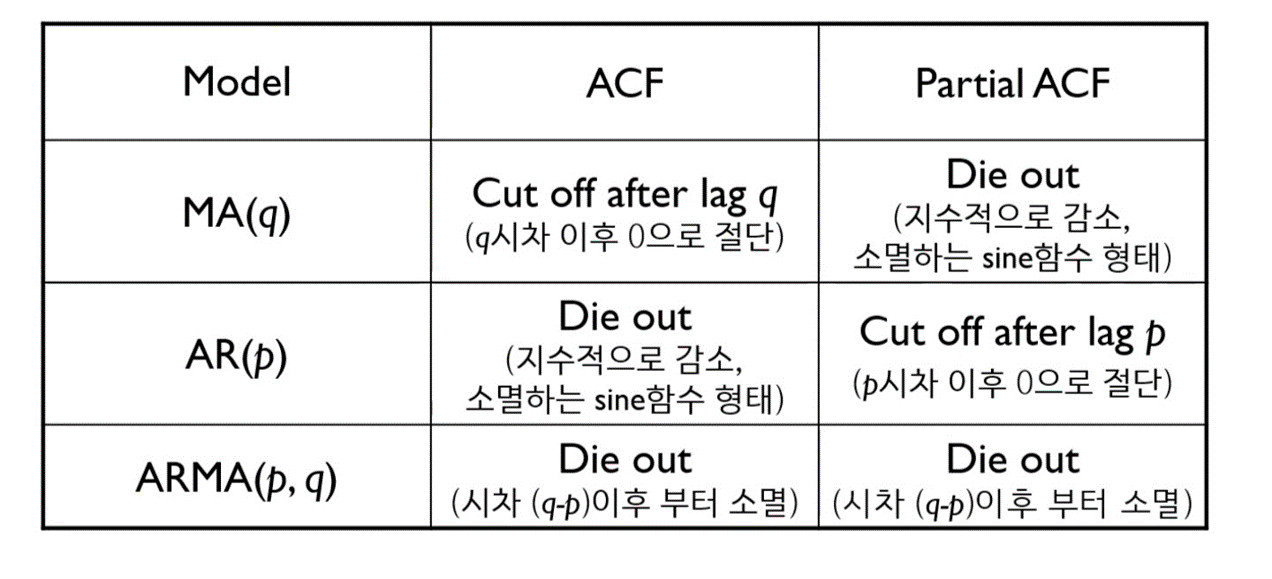

###3.Estimate parameter

In [ ]:
# ARIMA model fitting
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

model = ARIMA(train_data.values, order=(1,0,0))
model_fit = model.fit()
model_fit.summary()

# Q1) AIC score 17만?? 이렇게 커도 되나?
# Q2) 차분 안할시 AIC score 18만?? 이렇게 커도 되나?

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  901
Model:                     ARMA(1, 0)   Log Likelihood               -6329.346
Method:                       css-mle   S.D. of innovations            271.997
Date:                Mon, 16 Aug 2021   AIC                          12664.693
Time:                        04:40:25   BIC                          12679.103
Sample:                             0   HQIC                         12670.197
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        675.5911     13.876     48.689      0.000     648.395     702.787
ar.L1.y        0.3473      0.031     11.121      0.000       0.286       0.409
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8791           +0.0000j            2.8791            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
# ARIMA model fitting
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

model = ARIMA(train_data.values, order=(0,0,0))
model_fit = model.fit()
model_fit.summary()

# Q1) AIC score 17만?? 이렇게 커도 되나?
# Q2) 차분 안할시 AIC score 18만?? 이렇게 커도 되나?

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                21612
Model:                     ARMA(0, 0)   Log Likelihood             -111882.545
Method:                           css   S.D. of innovations             42.860
Date:                Mon, 16 Aug 2021   AIC                         223769.090
Time:                        01:15:59   BIC                         223785.052
Sample:                             0   HQIC                        223774.293
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.1701      0.292     96.624      0.000      27.599      28.741
==============================================================================
"""

###4. ARIMA

Diagonisis check

In [ ]:
# Parameter search

print('Examples of parameter combination for Seasonal ARIMA')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p,d,q))

aic = []
params=[] # optimal parameter순서 맞추려고 추가함
for i in pdq:
  try:
    model = ARIMA(train_data.values, order = (i))
    model_fit = model.fit()
    print(f'ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic,2))
    params.append(i) # optimal parameter순서 맞추려고 추가함
  except:
    continue

    # order = (2,1,1) 인 경우 계산이 안되어 예외처리함

Examples of parameter combination for Seasonal ARIMA
ARIMA : (0, 1, 0) >> AIC : 13004.43
ARIMA : (0, 1, 1) >> AIC : 12713.58
ARIMA : (0, 1, 2) >> AIC : 12642.34
ARIMA : (1, 1, 0) >> AIC : 12924.95
ARIMA : (1, 1, 1) >> AIC : 12650.25
ARIMA : (1, 1, 2) >> AIC : 12644.32
ARIMA : (2, 1, 0) >> AIC : 12827.47
ARIMA : (2, 1, 1) >> AIC : 12644.75
ARIMA : (2, 1, 2) >> AIC : 12646.21


In [ ]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((0, 1, 2), 12642.34)]

In [ ]:
train_data

,datetime,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth
0,2017-06-01 09:00:00,33.12,21.000000,0.0,0.000000,65.000000,2.400000,111.000000,1.000000,44.23,92.42
1,2017-06-01 10:00:00,50.16,21.333333,0.0,0.000000,65.000000,2.333333,112.000000,1.000000,NaN,NaN
2,2017-06-01 11:00:00,96.72,21.666667,0.0,0.000000,65.000000,2.266667,113.000000,1.000000,NaN,NaN
3,2017-06-01 12:00:00,120.96,22.000000,0.0,0.000000,65.000000,2.200000,114.000000,1.000000,76.04,158.50
4,2017-06-01 13:00:00,118.80,21.333333,0.0,0.000000,63.333333,2.433333,107.666667,1.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
21607,2019-11-18 16:00:00,7.44,9.666667,0.0,26.666667,40.000000,3.800000,311.666667,3.666667,NaN,NaN
21608,2019-11-18 17:00:00,0.00,8.333333,0.0,23.333333,40.000000,3.800000,312.333333,3.333333,NaN,NaN
21609,2019-11-18 18:00:00,0.00,7.000000,0.0,20.000000,40.000000,3.800000,313.000000,3.000000,-8.88,252.57
21610,2019-11-18 19:00:00,0.00,6.333333,0.0,20.000000,43.333333,3.733333,314.000000,3.000000,NaN,NaN


In [ ]:
test_data

,datetime,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth
21612,2019-11-18 21:00:00,0.0,5.000000,0.0,20.000000,50.000000,3.600000,316.000000,3.000000,NaN,NaN
21613,2019-11-18 22:00:00,0.0,4.666667,0.0,13.333333,48.333333,3.633333,316.333333,2.333333,NaN,NaN
21614,2019-11-18 23:00:00,0.0,4.333333,0.0,6.666667,46.666667,3.666667,316.666667,1.666667,NaN,NaN
21615,2019-11-19 00:00:00,0.0,4.000000,0.0,0.000000,45.000000,3.700000,317.000000,1.000000,NaN,NaN
21616,2019-11-19 01:00:00,0.0,3.833333,0.0,0.000000,45.000000,3.633333,318.666667,1.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
27011,2020-06-30 20:00:00,0.0,22.333333,0.0,20.000000,78.333333,2.566667,209.333333,3.000000,NaN,NaN
27012,2020-06-30 21:00:00,0.0,22.000000,0.0,20.000000,80.000000,2.300000,203.000000,3.000000,NaN,NaN
27013,2020-06-30 22:00:00,0.0,21.666667,0.0,13.333333,81.666667,2.266667,169.666667,2.333333,NaN,NaN
27014,2020-06-30 23:00:00,0.0,21.333333,0.0,6.666667,83.333333,2.233333,136.333333,1.666667,NaN,NaN


In [ ]:
model_opt = ARIMA(train_data.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  900
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -6317.169
Method:                       css-mle   S.D. of innovations            270.143
Date:                Mon, 16 Aug 2021   AIC                          12642.338
Time:                        04:40:58   BIC                          12661.548
Sample:                             1   HQIC                         12649.676
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2046      0.480     -0.426      0.670      -1.146       0.737
ma.L1.D.y     -0.6422      0.032    -20.290      0.000      -0.704      -0.580
ma.L2.D.y     -0.3060      0.032     -9.471      0.000      -0.369      -0.243
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0409           +0.0000j            1.0409            0.0000
MA.2           -3.1397           +0.0000j            3.1397            0.5000
-----------------------------------------------------------------------------
"""

use Model to forecast

In [ ]:
prediction = model_opt_fit.forecast(len(test_data))
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html#statsmodels.tsa.arima_model.ARIMAResults.forecast

predicted_value = prediction[0]
predicted_lb = prediction[2][:,0]
predicted_ub = prediction[2][:,1]


predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
test_data['predic'] = prediction[0]

In [ ]:
test_data

,solar_result,predic
day,,
2019-11-19,727.92,594.208137
2019-11-20,780.72,613.311745
2019-11-21,714.48,613.107173
2019-11-22,678.96,612.902601
2019-11-23,672.72,612.698029
2019-11-24,161.52,612.493458
2019-11-25,433.92,612.288886
2019-11-26,693.60,612.084314
2019-11-27,118.32,611.879742


In [ ]:
prediction[0]

array([594.2081368 , 613.31174462, 613.10717288, 612.90260115,
       612.69802941, 612.49345768, 612.28888594, 612.08431421,
       611.87974247, 611.67517074, 611.470599  , 611.26602727,
       611.06145553, 610.8568838 , 610.65231206, 610.44774033,
       610.24316859, 610.03859686, 609.83402512, 609.62945339,
       609.42488165, 609.22030992, 609.01573818, 608.81116645,
       608.60659471, 608.40202298, 608.19745124, 607.99287951,
       607.78830777, 607.58373604, 607.3791643 , 607.17459257,
       606.97002083, 606.7654491 , 606.56087736, 606.35630563,
       606.15173389, 605.94716216, 605.74259042, 605.53801869,
       605.33344695, 605.12887522, 604.92430348, 604.71973175,
       604.51516001, 604.31058828, 604.10601654, 603.90144481,
       603.69687307, 603.49230134, 603.2877296 , 603.08315787,
       602.87858613, 602.6740144 , 602.46944266, 602.26487093,
       602.06029919, 601.85572746, 601.65115572, 601.44658399,
       601.24201225, 601.03744052, 600.83286878, 600.62

In [ ]:
# dataset['solar_result']

datetime
2017-06-01 09:00:00     33.12
2017-06-01 10:00:00     50.16
2017-06-01 11:00:00     96.72
2017-06-01 12:00:00    120.96
2017-06-01 13:00:00    118.80
                        ...  
2020-06-30 20:00:00      0.00
2020-06-30 21:00:00      0.00
2020-06-30 22:00:00      0.00
2020-06-30 23:00:00      0.00
2020-07-01 00:00:00      0.00
Name: solar_result, Length: 27016, dtype: float64

In [ ]:
test_data

,solar_result,predic
datetime,,
2019-11-18 21:00:00,0.0,3.952753
2019-11-18 22:00:00,0.0,9.585211
2019-11-18 23:00:00,0.0,15.943943
2019-11-19 00:00:00,0.0,22.177856
2019-11-19 01:00:00,0.0,27.613682
...,...,...
2020-06-30 20:00:00,0.0,23.965994
2020-06-30 21:00:00,0.0,23.965659
2020-06-30 22:00:00,0.0,23.965324


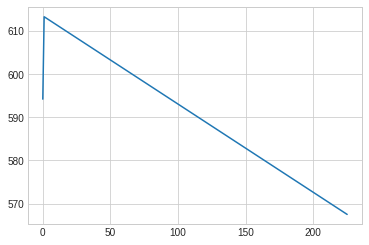

In [ ]:
plt.plot(prediction[0])

In [ ]:
prediction # prediction[1] standard error

(array([594.2081368 , 613.31174462, 613.10717288, 612.90260115,
        612.69802941, 612.49345768, 612.28888594, 612.08431421,
        611.87974247, 611.67517074, 611.470599  , 611.26602727,
        611.06145553, 610.8568838 , 610.65231206, 610.44774033,
        610.24316859, 610.03859686, 609.83402512, 609.62945339,
        609.42488165, 609.22030992, 609.01573818, 608.81116645,
        608.60659471, 608.40202298, 608.19745124, 607.99287951,
        607.78830777, 607.58373604, 607.3791643 , 607.17459257,
        606.97002083, 606.7654491 , 606.56087736, 606.35630563,
        606.15173389, 605.94716216, 605.74259042, 605.53801869,
        605.33344695, 605.12887522, 604.92430348, 604.71973175,
        604.51516001, 604.31058828, 604.10601654, 603.90144481,
        603.69687307, 603.49230134, 603.2877296 , 603.08315787,
        602.87858613, 602.6740144 , 602.46944266, 602.26487093,
        602.06029919, 601.85572746, 601.65115572, 601.44658399,
        601.24201225, 601.03744052, 600.

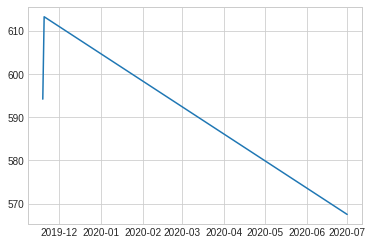

In [ ]:
plt.plot(predict_index, prediction[0])

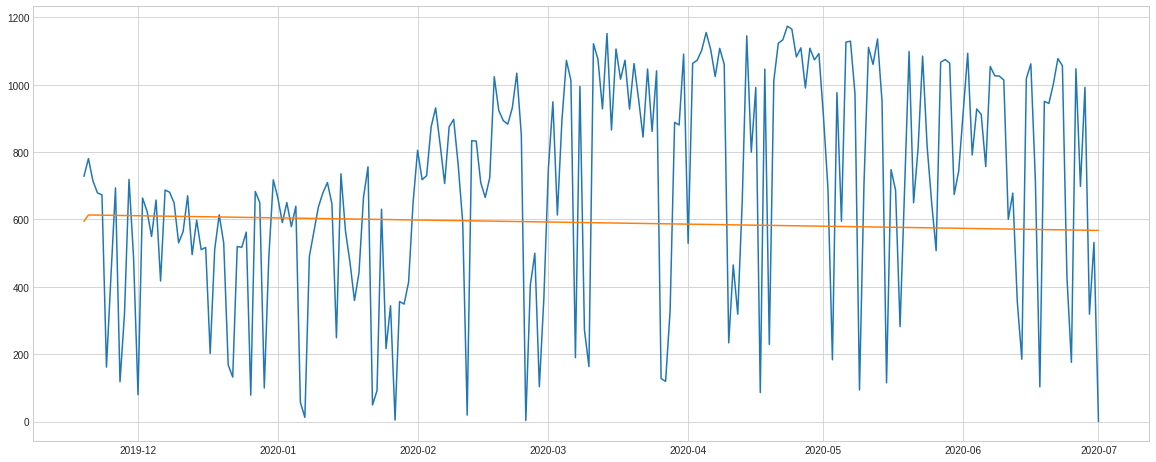

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(test_data)

Text(0.5, 0.98, 'ARIMA (2, 1, 2) Prediction Results (r2_score : -0.01)')

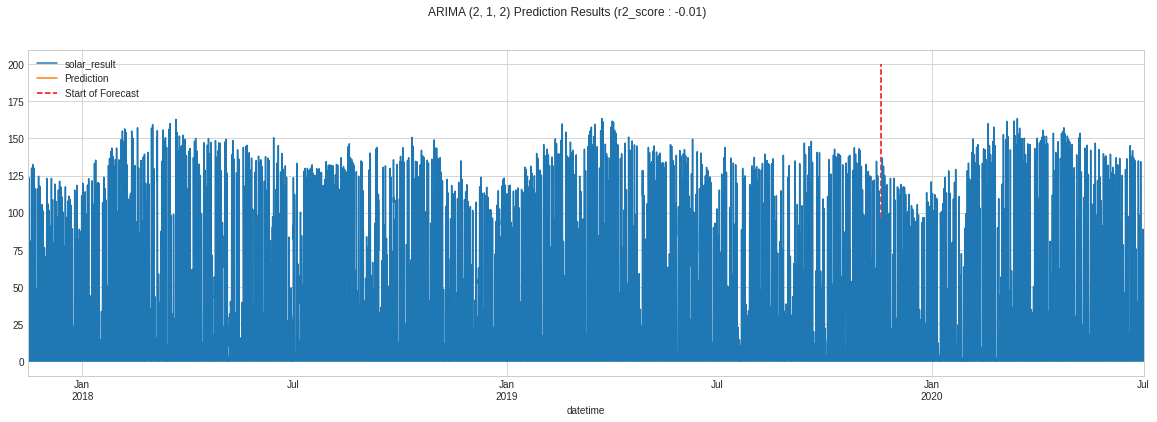

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
dataset[4000:].plot(ax=ax);
ax.vlines('2019-11-18', 0, 200, linestyle='--', color = 'r', label = 'Start of Forecast');
ax.plot(predict_index[4000:], predicted_value[4000:], label = 'Prediction')
# ax.plot(predict_index, predicted_value, label = 'Prediction')
# ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label='0.95 Prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score : {round(r2,2)})')

In [ ]:
len(predict_index)

5404

In [ ]:
test_data

,solar_result,predic
datetime,,
2019-11-18 21:00:00,0.0,3.952753
2019-11-18 22:00:00,0.0,9.585211
2019-11-18 23:00:00,0.0,15.943943
2019-11-19 00:00:00,0.0,22.177856
2019-11-19 01:00:00,0.0,27.613682
...,...,...
2020-06-30 20:00:00,0.0,23.965994
2020-06-30 21:00:00,0.0,23.965659
2020-06-30 22:00:00,0.0,23.965324


In [ ]:
len(test_data)

5404